In [ ]:
# 기본 setting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import warnings
warnings.filterwarnings(action = 'ignore')
pd.options.display.float_format = '{:.5f}'.format

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import plot_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import Callback
from seqeval.metrics import f1_score
from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import KFold , GridSearchCV , train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve,confusion_matrix
from sklearn.preprocessing import Binarizer


# 1. EDA
1. 결측치 확인
2. 무한대 확인
3. boxplot → 이상치 처리 → winsorizing

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_final = pd.read_csv('./data/df_over.csv',index_col=0)
df_final['거래소코드'] = df_final['거래소코드'].astype('str').str.zfill(6)
df_final['회계년도'] = pd.to_datetime(df_final['회계년도'],format='%Y')
df_final['회계년도'] = df_final['회계년도'].dt.year
df_final

## 1-1. 결측치 확인

In [ ]:
df_final.isna().sum()

## 1-2. 무한대 확인

In [ ]:
np.isinf(abs(df_final.iloc[:,6:38])).sum()

## 1-3. boxplot 이상치 처리

In [ ]:
# 이상치 확인을 위한 boxplot 그리기 전 초기작업
import seaborn as sns #heatmap 만들기 위한 라이브러리
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [30, 40]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

ncols = 8
nrows = 4

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

fig.set_size_inches((30, 40))

for col, ax in zip(df_final.columns[6:38], axs.T.ravel()):
    df_final[[col]].boxplot(ax=ax)
    
plt.show()

이상치 조정
- 너무 극단적인 이상치에 대해서는 winsorising 진행
- winsorize시 분포의 95% 외의 값은 max와 min 값으로 대체

In [ ]:
df_final_1 = df_final.iloc[:,6:38]

In [ ]:
# boxplot에서 보이는 이상치 처리 -> 5% winsorizing 활용
from scipy.stats.mstats import winsorize
for i in range(len(df_final_1.columns)):
  df_final_1.iloc[:,i]= winsorize(df_final_1.iloc[:,i], limits=[0.025, 0.025])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

ncols = 8
nrows = 4

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

fig.set_size_inches((30, 40))

for col, ax in zip(df_final_1.columns[6:38], axs.T.ravel()):
    df_final_1[[col]].boxplot(ax=ax)
    
plt.show()

# 2. 변수 선택 및 변수 세분화

In [ ]:
# 1) 독립변수, 종속변수 나누기
x = df_final_1.iloc[:,6:38]
x

## 2-1. StandardScaler

In [ ]:
# 2) standard scale로 변화를 확인해보고자 원본 독립변수들을 스케일링 진행
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x_scaled = scale.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns = x.columns)
x_scaled_df.head()

### 2-1-1. 히트맵을 이용한 다중공선성확인

In [ ]:
# 이상치 확인을 위한 boxplot 그리기 전 초기작업
import seaborn as sns #heatmap 만들기 위한 라이브러리
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib
from matplotlib import rc

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
#rc('font', family='AppleGothic') # Mac Os
rc('font', family='NanumGothic') # Windows Os
plt.rcParams['axes.unicode_minus'] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# 3) 상관행렬 시각화
mask_ut=np.triu(np.ones(x_scaled_df.corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(x_scaled_df.corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

### 2-1-2. VIF를 이용한 다중공선성 확인

In [ ]:
def vif(data):
    import pandas as pd
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    # VIF 출력을 위한 데이터 프레임 형성
    vif = pd.DataFrame()

    # VIF 값과 각 Feature 이름에 대해 설정
    vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    vif["features"] = data.columns 

    # VIF 값이 높은 순으로 정렬
    vif = vif.sort_values(by="VIF Factor", ascending=False)
    vif = vif.reset_index().drop(columns='index')
    
    return vif

In [ ]:
vif(x_scaled_df)

In [ ]:
# 총자본순이익률
x1_sd = x_scaled_df.drop('총자본순이익률',axis = 1)
# vif 확인
vif(x1_sd)

In [ ]:
# 매출액규모
x2_sd = x1_sd.drop('매출액규모',axis = 1)
# vif 확인
vif(x2_sd)

In [ ]:
# 자기자본회전율
x3_sd = x2_sd.drop('자기자본회전율',axis = 1)
# vif 확인
vif(x3_sd)

In [ ]:
# 자기자본비율
x4_sd = x3_sd.drop('자기자본비율',axis = 1)
# vif 확인
df_x4_sd = vif(x4_sd)
df_x4_sd

In [ ]:
# 자본금세전순이익률
x5_sd = x4_sd.drop('자본금세전순이익률',axis = 1)
# vif 확인
df_x5_sd = vif(x5_sd)
df_x5_sd

In [ ]:
# 3) 다중 공선성이 없는 변수들만 모은 데이터 프레임
df_x5_sd = df_x5_sd.reset_index(drop=True)['features']
df_x5_sd[df_x5_sd.index.max()+1] = 'y'
df_final_x5_sd = df_final[df_x5_sd]
df_final_x5_sd

### 2-1-3. 로지스틱 회귀 전 정규성 검정, 독립성 검정, 등분산성 검정

### 정규성 검정
- 표본이 30 넘어가서 중심극한정리에 따라 정규성 가정할 수 있지만
- shapiro-wilk test로 정규성 검정
> - H0 : 표본의 모집단이 정규분포를 따른다
> - H1 : 표본의 모집단이 정규분포를 따르지 않는다.

In [ ]:
from scipy.stats import shapiro, normaltest, anderson, kstest

def normal_test(test_name,x):
    normal = []
    notnormal = []
    if test_name == 'shapiro':
        for var in x.columns :
            stat, p  = shapiro(x[var].values)
            alpha = 0.05
            if p > alpha :
                normal.append(var)
            else :
                notnormal.append(var)
    elif test_name == 'normaltest':
        for var in x.columns :
            stat, p  = normaltest(x[var].values)
            alpha = 0.05
            if p > alpha :
                normal.append(var)
            else :
                notnormal.append(var)
    elif test_name == 'anderson':
        for var in x.columns :
            result  = anderson(x[var].values)
            normality = 0
            for i in range(len(result.critical_values)):
                sl, cv = result.significance_level[i], result.critical_values[i]
                if result.statistic < result.critical_values[i]:
                    normality +=1
                else :
                    normality +=0
            if normality > 2.5 :
                normal.append(var)
            else :
                notnormal.append(var)
    elif test_name == 'kstest':
        for var in x.columns :
            stat,p  = kstest(x[var].values, "norm")
            alpha = 0.05
            if p > alpha :
                normal.append(var)
            else :
                notnormal.append(var)
    else:
        pass
    return pd.DataFrame(normal, columns = ['normal']),pd.DataFrame(notnormal, columns = ['notnormal'])

In [ ]:
# 1-1) shapiro
## normal
## 귀무가설을 기각하지 못했다 -> 정규분포를 따른다
## notnormal
## 귀무가설을 기각 대립가설 채택 -> data 분포가 정규분포를 따르지 않는다.
normal_s,notnormal_s = normal_test('shapiro',x5_sd)
normal_s

In [ ]:
normal_a,notnormal_a = normal_test('anderson',x5_sd)
normal_a

In [ ]:
normal_ks,notnormal_ks = normal_test('kstest',x5_sd)
normal_ks

### 독립성 검정
- 자료 수집이 무선표집(random sampling)되었다면 만족한다고 봄

### 등분산성 검정
- H0 : 모집단의 표준편차가 같다(등분산)
- H1 : 모집단의 표준편차가 다르다(이분산)

In [ ]:
# H가 1인 경우 이분산성
from scipy.stats import bartlett
def bartlett_test(col, good, bad, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val =bartlett(good[i], bad[i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a

In [ ]:
# 이분산성 변수
x_hetero_sd = bartlett_test(x5_sd.columns, df_final_x5_sd[df_final_x5_sd['y']==0], df_final_x5_sd[df_final_x5_sd['y']==1], H = 1)
x_hetero_sd

In [ ]:
# 등분산성 변수
x_homo_sd =bartlett_test(x5_sd.columns, df_final_x5_sd[df_final_x5_sd['y']==0], df_final_x5_sd[df_final_x5_sd['y']==1], H = 0)
x_homo_sd

### 2-1-4. T-test(등분산성,이분산성 변수가 있다는 가정 하에)

In [ ]:
# 1) t_test
import scipy.stats as stats
def t_test(col, col_h0, col_h1, good, bad, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(good[i], bad[i], equal_var=True, alternative='two-sided')
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(good[i], bad[i], equal_var=False, alternative='two-sided')
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

In [ ]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest_sd = t_test(x5_sd.columns, x_homo_sd, x_hetero_sd, df_final_x5_sd[df_final_x5_sd['y']==0], df_final_x5_sd[df_final_x5_sd['y']==1], p_value=0.05)
x_ttest_sd

In [ ]:
# 3) t test 유의한 변수들만 모은 데이터 프레임
x_ttest_sd = x_ttest_sd.reset_index(drop=True)['변수']
x_ttest_sd[x_ttest_sd.index.max()+1] = 'y'
df_final_ttest_sd = df_final[x_ttest_sd]
df_final_ttest_sd

### 2-1-5. Lasso

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
lasso.fit(x5_sd, df_final_x5_sd['y'])
lasso_support = lasso.get_support()
lr_feature_sd = x5_sd.loc[:,lasso_support].columns.tolist()
print(str(len(lr_feature_sd)), 'selected features')

In [ ]:
# lasso 선택된 변수들만 모은 데이터 프레임
lr_feature_sd.append('y')
df_final_lasso_sd = df_final[lr_feature_sd]
df_final_lasso_sd

In [ ]:
lr_feature_sd

### 2-1-6. Stepwise

In [ ]:
def stepwise_feature_selection(feature, target, variables):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    warnings.filterwarnings("ignore")
    
    y = target ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = feature[selected_variables+[col]]
            model = sm.Logit(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = feature[selected_variables]
                selected_pval = sm.Logit(y,selected_X).fit(disp=0).pvalues[:]
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            presudo_r_squared = sm.Logit(y,feature[selected_variables]).fit(disp=0).prsquared
            r_squared.append(presudo_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    
    # 시각화
    fig = plt.figure(figsize=(40,40))
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)])
    plt.plot(steps,r_squared, marker='o')
    plt.ylabel('pseudo R Squared')
    plt.grid(True)
    plt.show()

    return selected_variables
    
selected_variables = stepwise_feature_selection(x5_sd, df_final_x5_sd['y'],x5_sd.columns.tolist())

### 2-1-7. Step8
'자기자본순이익률','금융비용대비매출액','총자산증가율','자기자본증가율','총자본투자효율','부채비율','차입금의존도','총자산규모'

In [ ]:
# select된 변수 들고오기
select_sd = ['자기자본순이익률','금융비용대비매출액','총자산증가율','자기자본증가율','총자본투자효율','부채비율','차입금의존도','총자산규모']
select_sd.append('y')
df_select_sd = df_final[select_sd]
df_select_sd

In [ ]:
# 상관행렬 시각화
mask_ut=np.triu(np.ones(df_select_sd.drop('y',axis=1).corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(df_select_sd.drop('y',axis=1).corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

In [ ]:
df_final_x6_sd = pd.concat([df_select_sd, df_final[['감사의견코드','산업분류','회계년도']]],axis=1)
df_final_x6_sd

In [ ]:
df_final_x6_sd.to_csv('./data/df_final_x6_sd.csv')

## 2-2. RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_robust_df = scaler.fit_transform(x)
x_robust_df = pd.DataFrame(x_robust_df, columns = x.columns)
x_robust_df.head()

### 2-2-1. 히트맵을 이용한 다중공선성확인

In [ ]:
# 3. robust 상관행렬 시각화
mask_ut=np.triu(np.ones(x_robust_df.corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(x_robust_df.corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

### 2-2-2. VIF를 이용한 다중공선성 확인

In [ ]:
vif(x_robust_df)

In [ ]:
# 총자본순이익률
x1_rb = x_robust_df.drop('총자본순이익률',axis = 1)
# vif 확인
vif(x1_rb)

In [ ]:
# 매출액규모
x2_rb = x1_rb.drop('매출액규모',axis = 1)
# vif 확인
vif(x2_rb)

In [ ]:
# 자기자본회전율
x3_rb = x2_rb.drop('자기자본회전율',axis = 1)
# vif 확인
vif(x3_rb)

In [ ]:
# 자기자본비율
x4_rb = x3_rb.drop('자기자본비율',axis = 1)
# vif 확인
vif(x4_rb)
# df_x3_rb = vif(x3_rb)
# df_x3_rb

In [ ]:
# 자본금세전순이익률
x5_rb = x4_rb.drop('자본금세전순이익률',axis = 1)
# vif 확인
vif(x5_rb)

In [ ]:
# 매출액세전순이익률
x6_rb = x5_rb.drop('매출액세전순이익률',axis = 1)
# vif 확인
df_x6_rb = vif(x6_rb)
df_x6_rb

In [ ]:
# 3) 다중 공선성이 없는 변수들만 모은 데이터 프레임
df_x6_rb = df_x6_rb.reset_index(drop=True)['features']
df_x6_rb[df_x6_rb.index.max()+1] = 'y'
df_final_x6_rb = df_final[df_x6_rb]
df_final_x6_rb

In [ ]:
# 상관행렬 시각화
mask_ut=np.triu(np.ones(x6_rb.corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(x6_rb.corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

### 2-2-3. 로지스틱 회귀 전 정규성 검정, 독립성 검정, 등분산성 검정

In [ ]:
normal_s,notnormal_s = normal_test('shapiro',x6_rb)
normal_s

In [ ]:
normal_a,notnormal_a = normal_test('anderson',x6_rb)
normal_a

In [ ]:
normal_ks,notnormal_ks = normal_test('kstest',x6_rb)
normal_ks

In [ ]:
# 이분산성 변수
x_hetero_rb = bartlett_test(x6_rb.columns, df_final_x6_rb[df_final_x6_rb['y']==0], df_final_x6_rb[df_final_x6_rb['y']==1], H = 1)
x_hetero_rb

In [ ]:
# 등분산성 변수
x_homo_rb =bartlett_test(x6_rb.columns, df_final_x6_rb[df_final_x6_rb['y']==0], df_final_x6_rb[df_final_x6_rb['y']==1], H = 0)
x_homo_rb

### 2-2-4. T-test(등분산성,이분산성 변수가 있다는 가정 하에)

In [ ]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest_rb = t_test(x6_rb.columns, x_homo_rb, x_hetero_rb, df_final_x6_rb[df_final_x6_rb['y']==0], df_final_x6_rb[df_final_x6_rb['y']==1], p_value=0.05)
x_ttest_rb

In [ ]:
# 3) t test 유의한 변수들만 모은 데이터 프레임
x_ttest_rb = x_ttest_rb.reset_index(drop=True)['변수']
x_ttest_rb[x_ttest_rb.index.max()+1] = 'y'
df_final_ttest_rb = df_final[x_ttest_rb]
df_final_ttest_rb

### 2-2-5. Lasso

In [ ]:
lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
lasso.fit(x6_rb, df_final_x6_rb['y'])
lasso_support = lasso.get_support()
lr_feature_rb = x6_rb.loc[:,lasso_support].columns.tolist()
print(str(len(lr_feature_rb)), 'selected features')

In [ ]:
# lasso 선택된 변수들만 모은 데이터 프레임
lr_feature_rb.append('y')
df_final_lasso_rb = df_final[lr_feature_rb]
df_final_lasso_rb

In [ ]:
lr_feature_rb

### 2-2-6. Stepwise

In [ ]:
def stepwise_feature_selection(feature, target, variables):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    warnings.filterwarnings("ignore")
    
    y = target ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = feature[selected_variables+[col]]
            model = sm.Logit(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = feature[selected_variables]
                selected_pval = sm.Logit(y,selected_X).fit(disp=0).pvalues[:]
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            presudo_r_squared = sm.Logit(y,feature[selected_variables]).fit(disp=0).prsquared
            r_squared.append(presudo_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    
    # 시각화
    fig = plt.figure(figsize=(40,40))
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)])
    plt.plot(steps,r_squared, marker='o')
    plt.ylabel('pseudo R Squared')
    plt.grid(True)
    plt.show()

    return selected_variables
    
selected_variables = stepwise_feature_selection(x6_rb, df_final_x6_rb['y'],x6_rb.columns.tolist())

### 2-2-7. Step10
'유동비율','비유동자산회전율','금융비용대비매출액','매출원가율','매출채권회전율','총자산규모','이자보상배율','유형고정자산회전율','재고자산회전율','차입금의존도'

In [ ]:
# select된 변수 들고오기
select_rb = ['유동비율','비유동자산회전율','금융비용대비매출액','매출원가율','매출채권회전율','총자산규모','이자보상배율','유형고정자산회전율','재고자산회전율','차입금의존도']
select_rb.append('y')
df_select_rb = df_final[select_rb]
df_select_rb

In [ ]:
# 상관행렬 시각화
mask_ut=np.triu(np.ones(df_select_rb.drop('y',axis=1).corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(df_select_rb.drop('y',axis=1).corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

In [ ]:
df_final_x7_rb = pd.concat([df_select_rb, df_final[['감사의견코드','산업분류','회계년도']]],axis=1)
df_final_x7_rb

In [ ]:
df_final_x7_rb.to_csv('./data/df_final_x7_rb.csv')

## 2-3. MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_minmax_df = scaler.fit_transform(x)
x_minmax_df = pd.DataFrame(x_minmax_df, columns = x.columns)
x_minmax_df.head()

### 2-3-1. 히트맵을 이용한 다중공선성확인

In [ ]:
# 3. standard 상관행렬 시각화
mask_ut=np.triu(np.ones(x_minmax_df.corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(x_minmax_df.corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

### 2-3-2. VIF를 이용한 다중공선성 확인

In [ ]:
vif(x_minmax_df)

In [ ]:
# 부가가치율
x1_mm = x_minmax_df.drop('부가가치율',axis = 1)
# vif 확인
vif(x1_mm)

In [ ]:
# 현금흐름
x2_mm = x1_mm.drop('현금흐름',axis = 1)
# vif 확인
vif(x2_mm)

In [ ]:
# 노동소득분배율
x3_mm = x2_mm.drop('노동소득분배율',axis = 1)
# vif 확인
vif(x3_mm)

In [ ]:
# 순이익증가율
x4_mm = x3_mm.drop('순이익증가율',axis = 1)
# vif 확인
vif(x4_mm)

In [ ]:
# 총자본순이익률
x5_mm = x4_mm.drop('총자본순이익률',axis = 1)
# vif 확인
vif(x5_mm)

In [ ]:
# 총자본투자효율
x6_mm = x5_mm.drop('총자본투자효율',axis = 1)
# vif 확인
vif(x6_mm)

In [ ]:
# 매출액규모
x7_mm = x6_mm.drop('매출액규모',axis = 1)
# vif 확인
vif(x7_mm)

In [ ]:
# 매출액세전순이익률
x8_mm = x7_mm.drop('매출액세전순이익률',axis = 1)
# vif 확인
vif(x8_mm)

In [ ]:
# 자기자본증가율
x9_mm = x8_mm.drop('자기자본증가율',axis = 1)
# vif 확인
vif(x9_mm)

In [ ]:
# 자기자본순이익률
x10_mm = x9_mm.drop('자기자본순이익률',axis = 1)
# vif 확인
vif(x10_mm)

In [ ]:
# 매출액영업이익률
x11_mm = x10_mm.drop('매출액영업이익률',axis = 1)
# vif 확인
vif(x11_mm)

In [ ]:
# 총자본회전율
x12_mm = x11_mm.drop('총자본회전율',axis = 1)
# vif 확인
vif(x12_mm)

In [ ]:
# 자기자본비율
x13_mm = x12_mm.drop('자기자본비율',axis = 1)
# vif 확인
vif(x13_mm)

In [ ]:
# 자본금세전순이익률
x14_mm = x13_mm.drop('자본금세전순이익률',axis = 1)
# vif 확인
vif(x14_mm)

In [ ]:
# 자기자본회전율
x15_mm = x14_mm.drop('자기자본회전율',axis = 1)
# vif 확인
df_x15_mm = vif(x15_mm)
df_x15_mm

In [ ]:
# 3) 다중 공선성이 없는 변수들만 모은 데이터 프레임
df_x15_mm = df_x15_mm.reset_index(drop=True)['features']
df_x15_mm[df_x15_mm.index.max()+1] = 'y'
df_final_x15_mm = df_final[df_x15_mm]
df_final_x15_mm

In [ ]:
# 상관행렬 시각화
mask_ut=np.triu(np.ones(x15_mm.corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(x15_mm.corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

### 2-3-3. 로지스틱 회귀 전 정규성 검정, 독립성 검정, 등분산성 검정

In [ ]:
normal_s,notnormal_s = normal_test('shapiro',x15_mm)
normal_s

In [ ]:
normal_a,notnormal_a = normal_test('anderson',x15_mm)
normal_a

In [ ]:
normal_ks,notnormal_ks = normal_test('kstest',x15_mm)
normal_ks

In [ ]:
# 이분산성 변수
x_hetero_mm = bartlett_test(x15_mm.columns, df_final_x15_mm[df_final_x15_mm['y']==0], df_final_x15_mm[df_final_x15_mm['y']==1], H = 1)
x_hetero_mm

In [ ]:
# 등분산성 변수
x_homo_mm =bartlett_test(x15_mm.columns, df_final_x15_mm[df_final_x15_mm['y']==0], df_final_x15_mm[df_final_x15_mm['y']==1], H = 0)
x_homo_mm

### 2-3-4. T-test(등분산성,이분산성 변수가 있다는 가정 하에)

In [ ]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest_mm = t_test(x15_mm.columns, x_homo_mm, x_hetero_mm, df_final_x15_mm[df_final_x15_mm['y']==0], df_final_x15_mm[df_final_x15_mm['y']==1], p_value=0.05)
x_ttest_mm

In [ ]:
# 3) t test 유의한 변수들만 모은 데이터 프레임
x_ttest_mm = x_ttest_mm.reset_index(drop=True)['변수']
x_ttest_mm[x_ttest_mm.index.max()+1] = 'y'
df_final_ttest_mm = df_final[x_ttest_mm]
df_final_ttest_mm

### 2-3-5. Lasso

In [ ]:
lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
lasso.fit(x15_mm, df_final_x15_mm['y'])
lasso_support = lasso.get_support()
lr_feature_mm = x15_mm.loc[:,lasso_support].columns.tolist()
print(str(len(lr_feature_mm)), 'selected features')

In [ ]:
# lasso 선택된 변수들만 모은 데이터 프레임
lr_feature_mm.append('y')
df_final_lasso_mm = df_final[lr_feature_mm]
df_final_lasso_mm

In [ ]:
lr_feature_mm

### 2-3-6. Stepwise

In [ ]:
def stepwise_feature_selection(feature, target, variables):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    warnings.filterwarnings("ignore")
    
    y = target ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = feature[selected_variables+[col]]
            model = sm.Logit(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = feature[selected_variables]
                selected_pval = sm.Logit(y,selected_X).fit(disp=0).pvalues[:]
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            presudo_r_squared = sm.Logit(y,feature[selected_variables]).fit(disp=0).prsquared
            r_squared.append(presudo_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    
    # 시각화
    fig = plt.figure(figsize=(40,40))
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)])
    plt.plot(steps,r_squared, marker='o')
    plt.ylabel('pseudo R Squared')
    plt.grid(True)
    plt.show()

    return selected_variables
    
selected_variables = stepwise_feature_selection(x15_mm, df_final_x15_mm['y'],x15_mm.columns.tolist())

### 2-3-7. Step7
'유동비율','총자산증가율','총자산규모','금융비용대비매출액','운전자산회전율','부채비율','차입금의존도'

In [ ]:
# select된 변수 들고오기
select_mm = ['유동비율','총자산증가율','총자산규모','금융비용대비매출액','운전자산회전율','부채비율','차입금의존도']
select_mm.append('y')
df_select_mm = df_final[select_mm]
df_select_mm

In [ ]:
# 상관행렬 시각화
mask_ut=np.triu(np.ones(df_select_mm.drop('y',axis=1).corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(df_select_mm.drop('y',axis=1).corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

In [ ]:
df_final_x13_mm = pd.concat([df_select_mm, df_final[['감사의견코드','산업분류','회계년도']]],axis=1)
df_final_x13_mm

In [ ]:
df_final_x13_mm.to_csv('./data/df_final_x13_mm.csv')

## 2-4. LogScaler

In [ ]:
df_final_log = x.copy()

In [ ]:
# 1) log scale 만들기
skew_feats = df_final_log.drop(['총자산규모','매출액규모'],axis=1).columns
# 기존 값 : np.log1p(df_final_log.loc[:,skew_feats])
# 2) BOX-COX 변환 : 절대값자연로그에 원래 부호를 붙임(마이너스인 경우도 사용이 가능하다.)
df_final_log.loc[:,skew_feats] = (np.sign(df_final_log.loc[:,skew_feats]))*(np.log1p(np.abs(df_final_log.loc[:,skew_feats])))

In [ ]:
df_final_log.loc[:,skew_feats]

In [ ]:
# 3) histogram 그리기
n = 0
f, grid = plt.subplots(8, 4, figsize=(20, 50))
for row in grid:
    for ax in row:
        col = df_final_log.columns[n]
        ax.hist(df_final_log[col], bins=max(df_final_log[col].nunique()//20, 10))
        ax.set_title(col)
        n += 1

### 2-4-1. 히트맵을 이용한 다중공선성 확인

In [ ]:
# 3. standard 상관행렬 시각화
mask_ut=np.triu(np.ones(df_final_log.corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(df_final_log.corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

### 2-4-2. VIF를 이용한 다중공선성 확인

In [ ]:
vif(df_final_log)

In [ ]:
# 총자산규모
x1_log = df_final_log.drop('총자산규모',axis = 1)
# vif 확인
vif(x1_log)

In [ ]:
# 총자본회전율
x2_log = x1_log.drop('총자본회전율',axis = 1)
# vif 확인
vif(x2_log)

In [ ]:
# 매출액규모
x3_log = x2_log.drop('매출액규모',axis = 1)
# vif 확인
vif(x3_log)

In [ ]:
# 당좌비율
x4_log = x3_log.drop('당좌비율',axis = 1)
# vif 확인
vif(x4_log)

In [ ]:
# 자기자본회전율
x5_log = x4_log.drop('자기자본회전율',axis = 1)
# vif 확인
vif(x5_log)

In [ ]:
# 자기자본비율
x6_log = x5_log.drop('자기자본비율',axis = 1)
# vif 확인
vif(x6_log)

In [ ]:
# 비유동자산회전율
x7_log = x6_log.drop('비유동자산회전율',axis = 1)
# vif 확인
vif(x7_log)

In [ ]:
# 총자본순이익률
x8_log = x7_log.drop('총자본순이익률',axis = 1)
# vif 확인
vif(x8_log)

In [ ]:
# 매출채권회전율
x9_log = x8_log.drop('매출채권회전율',axis = 1)
# vif 확인
vif(x9_log)

In [ ]:
# 부채비율
x10_log = x9_log.drop('부채비율',axis = 1)
# vif 확인
vif(x10_log)

In [ ]:
# 총자본투자효율
x11_log = x10_log.drop('총자본투자효율',axis = 1)
# vif 확인
vif(x11_log)

In [ ]:
# 유동비율
x12_log = x11_log.drop('유동비율',axis = 1)
# vif 확인
vif(x12_log)

In [ ]:
# 자본금세전순이익률
x13_log = x12_log.drop('자본금세전순이익률',axis = 1)
# vif 확인
vif(x13_log)

In [ ]:
# 매출액세전순이익률
x14_log = x13_log.drop('매출액세전순이익률',axis = 1)
# vif 확인
vif(x14_log)

In [ ]:
# 매출원가율
x15_log = x14_log.drop('매출원가율',axis = 1)
# vif 확인
vif(x15_log)

In [ ]:
# 부가가치율
x16_log = x15_log.drop('부가가치율',axis = 1)
# vif 확인
vif(x16_log)
# df_x16_log = vif(x16_log)
# df_x16_log

In [ ]:
# 유형고정자산회전율
x17_log = x16_log.drop('유형고정자산회전율',axis = 1)
# vif 확인
df_x17_log = vif(x17_log)
df_x17_log

In [ ]:
# 3) 다중 공선성이 없는 변수들만 모은 데이터 프레임
df_x17_log = df_x17_log.reset_index(drop=True)['features']
df_x17_log[df_x17_log.index.max()+1] = 'y'
df_final_x17_log = df_final[df_x17_log]
df_final_x17_log

### 2-4-3. 로지스틱 회귀 전 정규성 검정, 독립성 검정, 등분산성 검정

In [ ]:
normal_s,notnormal_s = normal_test('shapiro',x17_log)
normal_s

In [ ]:
normal_a,notnormal_a = normal_test('anderson',x17_log)
normal_a

In [ ]:
normal_ks,notnormal_ks = normal_test('kstest',x17_log)
normal_ks

In [ ]:
# 이분산성 변수
x_hetero_log = bartlett_test(x17_log.columns, df_final_x17_log[df_final_x17_log['y']==0], df_final_x17_log[df_final_x17_log['y']==1], H = 1)
x_hetero_log

In [ ]:
# 등분산성 변수
x_homo_log =bartlett_test(x17_log.columns, df_final_x17_log[df_final_x17_log['y']==0], df_final_x17_log[df_final_x17_log['y']==1], H = 0)
x_homo_log

### 2-4-4. T-test(등분산성,이분산성 변수가 있다는 가정 하에)

In [ ]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest_log = t_test(x17_log.columns, x_homo_log, x_hetero_log, df_final_x17_log[df_final_x17_log['y']==0], df_final_x17_log[df_final_x17_log['y']==1], p_value=0.05)
x_ttest_log

In [ ]:
# 3) t test 유의한 변수들만 모은 데이터 프레임
x_ttest_log = x_ttest_log.reset_index(drop=True)['변수']
x_ttest_log[x_ttest_log.index.max()+1] = 'y'
df_final_ttest_log = df_final[x_ttest_log]
df_final_ttest_log

### 2-4-5. Lasso

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
lasso.fit(x17_log, df_final_x17_log['y'])
lasso_support = lasso.get_support()
lr_feature_log = x17_log.loc[:,lasso_support].columns.tolist()
print(str(len(lr_feature_log)), 'selected features')

In [ ]:
# lasso 선택된 변수들만 모은 데이터 프레임
lr_feature_log.append('y')
df_final_lasso_log = df_final[lr_feature_log]
df_final_lasso_log

In [ ]:
lr_feature_log

### 2-4-6. Stepwise

In [ ]:
def stepwise_feature_selection(feature, target, variables):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    warnings.filterwarnings("ignore")
    
    y = target ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = feature[selected_variables+[col]]
            model = sm.Logit(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = feature[selected_variables]
                selected_pval = sm.Logit(y,selected_X).fit(disp=0).pvalues[:]
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            presudo_r_squared = sm.Logit(y,feature[selected_variables]).fit(disp=0).prsquared
            r_squared.append(presudo_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    
    # 시각화
    fig = plt.figure(figsize=(40,40))
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)])
    plt.plot(steps,r_squared, marker='o')
    plt.ylabel('pseudo R Squared')
    plt.grid(True)
    plt.show()

    return selected_variables
    
selected_variables = stepwise_feature_selection(x17_log, df_final_x17_log['y'],x17_log.columns.tolist())

### 2-4-7. Step8
'부채상환계수','재고자산회전율','총자산증가율','운전자산회전율','차입금의존도','순이익증가율','자기자본순이익률','노동소득분배율'

In [ ]:
# select된 변수 들고오기
select_log = ['부채상환계수','재고자산회전율','총자산증가율','운전자산회전율','차입금의존도','순이익증가율','자기자본순이익률','노동소득분배율']
select_log.append('y')
df_select_log = df_final[select_log]
df_select_log

In [ ]:
# 상관행렬 시각화
mask_ut=np.triu(np.ones(df_select_log.drop('y',axis=1).corr().shape)).astype(bool)  # 배열 행렬에 위쪽 삼각형 반환 -> True
plt.figure(figsize=(30,30))
sns.heatmap(df_select_log.drop('y',axis=1).corr(method='pearson'), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
              annot_kws={"size": 10}, linewidths=.5, mask=mask_ut)
plt.show()

In [ ]:
df_final_x17_log = pd.concat([df_select_log, df_final[['감사의견코드','산업분류','회계년도']]],axis=1)
df_final_x17_log

In [ ]:
df_final_x17_log.to_csv('./data/df_final_x17_log.csv')

# 3. 기업 기준/ 연도 기준 logistic 성능 비교

In [1]:
# 기본 setting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import warnings
warnings.filterwarnings(action = 'ignore')
pd.options.display.float_format = '{:.5f}'.format

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import plot_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import KFold , GridSearchCV , train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve,confusion_matrix
from sklearn.preprocessing import Binarizer

## 3-1. 모델 돌리기 전 함수 만들기

### 3-1-1. 기업 기준 train_test_split 8:2

In [2]:
import pandas as pd
import numpy as np

In [130]:
df_final = pd.read_csv('./data/df_over.csv',index_col=0)
df_final['거래소코드'] = df_final['거래소코드'].astype('str').str.zfill(6)
df_final['회계년도'] = pd.to_datetime(df_final['회계년도'],format='%Y')
df_final['회계년도'] = df_final['회계년도'].dt.year
df_final

,회사명,거래소코드,회계년도,산업분류,감사의견코드,y,자기자본비율,부채비율,유동비율,당좌비율,...,운전자산회전율,총자산증가율,유형자산증가율,매출액증가율,순이익증가율,자기자본증가율,총자본투자효율,부가가치율,노동소득분배율,현금흐름
0,(주)CMG제약,058820,2011,제조업,1,0.00000,75.62749,47.26749,230.99635,77.28779,...,146.66914,25.66922,9.44116,53.83186,831.58011,158.83360,12.63467,27.23903,56.20416,-3.37997
1,(주)CMG제약,058820,2012,제조업,1,0.00000,41.79746,190.41433,424.28694,92.83109,...,47.92797,54.40705,-3.00451,0.74770,-687.67762,-21.70104,-5.11308,-15.50104,-0.00000,-11.28443
2,(주)CMG제약,058820,2013,제조업,1,0.00000,95.59773,16.32119,633.69602,88.09871,...,44.25704,25.22627,11.19392,22.78041,720.96779,212.64729,6.85240,23.12858,58.08721,-7.42957
3,(주)CMG제약,058820,2014,제조업,1,0.00000,85.91485,17.05338,422.69187,83.27042,...,77.52048,1.13891,76.94049,11.87046,-50.81320,0.50627,5.25856,17.74315,76.62273,0.18906
4,(주)CMG제약,058820,2015,제조업,1,0.00000,86.33468,16.44248,358.93927,81.39065,...,100.56523,1.06613,-6.08394,15.52010,-369.91131,1.59636,4.99393,14.74719,85.08907,2.76669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10654,흥구석유(주),024060,2016,도매 및 소매업,1,0.00000,88.15917,14.97938,512.17096,85.34895,...,902.26309,2.76753,-5.88494,-10.44421,-39.41557,1.10231,0.81332,0.60275,0.00000,0.83877
10655,흥구석유(주),024060,2017,도매 및 소매업,1,0.00000,87.21896,14.94747,170.53091,83.77533,...,1850.60804,0.51328,-0.31466,9.57926,-21.85009,0.54119,0.24311,0.16709,0.00000,1.69081
10656,흥구석유(주),024060,2018,도매 및 소매업,1,0.00000,88.57968,11.37669,190.72729,75.54444,...,2062.24257,-2.65019,-0.11878,8.59591,-7.19164,0.47088,0.06570,0.04114,0.00000,-0.41901
10657,흥구석유(주),024060,2019,도매 및 소매업,1,0.00000,95.36694,8.62898,448.80343,89.98449,...,648.08224,7.46055,-7.72428,-11.78601,654.09380,10.17871,0.58948,0.42817,0.00000,1.62528


In [132]:
df_final_1 = df_final.iloc[:,6:38]

In [133]:
# 1) boxplot에서 보이는 이상치 처리 -> 5% winsorizing 활용
from scipy.stats.mstats import winsorize
for i in range(len(df_final_1.columns)):
  df_final_1.iloc[:,i]= winsorize(df_final_1.iloc[:,i], limits=[0.025, 0.025])

In [134]:
# 2) winsor 하고 원 데이터에 합치기
df_over = pd.concat([df_final.iloc[:,:6],df_final_1],axis=1)
df_over

,회사명,거래소코드,회계년도,산업분류,감사의견코드,y,자기자본비율,부채비율,유동비율,당좌비율,...,운전자산회전율,총자산증가율,유형자산증가율,매출액증가율,순이익증가율,자기자본증가율,총자본투자효율,부가가치율,노동소득분배율,현금흐름
0,(주)CMG제약,058820,2011,제조업,1,0.00000,75.62749,47.26749,230.99635,77.28779,...,146.66914,25.66922,9.44116,53.83186,831.58011,118.89191,12.63467,27.23903,56.20416,-3.37997
1,(주)CMG제약,058820,2012,제조업,1,0.00000,41.79746,190.41433,424.28694,92.83109,...,47.92797,54.40705,-3.00451,0.74770,-687.67762,-21.70104,-5.11308,-15.50104,-0.00000,-11.28443
2,(주)CMG제약,058820,2013,제조업,1,0.00000,95.59773,16.32119,633.69602,88.09871,...,44.25704,25.22627,11.19392,22.78041,720.96779,118.89191,6.85240,23.12858,58.08721,-7.42957
3,(주)CMG제약,058820,2014,제조업,1,0.00000,85.91485,17.05338,422.69187,83.27042,...,77.52048,1.13891,76.94049,11.87046,-50.81320,0.50627,5.25856,17.74315,76.62273,0.18906
4,(주)CMG제약,058820,2015,제조업,1,0.00000,86.33468,16.44248,358.93927,81.39065,...,100.56523,1.06613,-6.08394,15.52010,-369.91131,1.59636,4.99393,14.74719,85.08907,2.76669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10654,흥구석유(주),024060,2016,도매 및 소매업,1,0.00000,88.15917,14.97938,512.17096,85.34895,...,902.26309,2.76753,-5.88494,-10.44421,-39.41557,1.10231,0.81332,0.60275,0.00000,0.83877
10655,흥구석유(주),024060,2017,도매 및 소매업,1,0.00000,87.21896,14.94747,170.53091,83.77533,...,1850.60804,0.51328,-0.31466,9.57926,-21.85009,0.54119,0.24311,0.16709,0.00000,1.69081
10656,흥구석유(주),024060,2018,도매 및 소매업,1,0.00000,88.57968,11.37669,190.72729,75.54444,...,2062.24257,-2.65019,-0.11878,8.59591,-7.19164,0.47088,0.06570,0.04114,0.00000,-0.41901
10657,흥구석유(주),024060,2019,도매 및 소매업,1,0.00000,95.36694,8.62898,448.80343,89.98449,...,648.08224,7.46055,-7.72428,-11.78601,654.09380,10.17871,0.58948,0.42817,0.00000,1.62528


In [83]:
# 3) train, test 나누는 기본 함수
def data(df):
    #  '감사의견코드','산업분류','y' 카테고리로 만들기
    df[['감사의견코드','산업분류']] = df[['감사의견코드','산업분류']].astype('category')
    X = df.drop(['y','회계년도','회사명','거래소코드'], axis=1)
    y = df[['y']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=121, stratify=y, test_size=0.2)
    X_train_over, y_train_over = SMOTENC(sampling_strategy = 'auto', categorical_features=[0,1],random_state=121).fit_resample(X_train, y_train)

    # smotenc -> 산업분류 : 더미변수 / 감사의견코드 : laber_encoding
    def category_origin(X):
        X = pd.concat([X,pd.get_dummies(X['산업분류'],drop_first=True)],axis=1)
        X.drop('산업분류',axis=1,inplace=True)
        le = LabelEncoder()
        X['감사의견코드'] = le.fit_transform(X['감사의견코드'])
        return X
    X_train_over = category_origin(X_train_over)
    X_test = category_origin(X_test)
    
    return X_train_over, X_test, y_train_over, y_test

In [135]:
# 4) train, test 나누는 year기준 함수
def data_year(df):
    #  '감사의견코드','산업분류','y' 카테고리로 만들기
    X = df.drop(['y','회사명','회사명','거래소코드'], axis=1)
    y = df[['y']]
    df[['감사의견코드','산업분류','y']] = df[['감사의견코드','산업분류','y']].astype('category')


    # 2018년까지 X_train / 2019,2020년 y_train
    
    X_train = X[X['회계년도']<2019].drop('회계년도',axis=1)
    X_test = X[X['회계년도']>2018].drop('회계년도',axis=1)
    y_train = y.iloc[X_train.index]
    y_test = y.iloc[X_test.index]
    X_train_over, y_train_over = SMOTENC(sampling_strategy = 'auto', categorical_features=[0,1],random_state=121).fit_resample(X_train, y_train)

    # smotenc -> 산업분류 : 더미변수 / 감사의견코드 : laber_encoding
    def category_origin(X):
        X = pd.concat([X,pd.get_dummies(X['산업분류'],drop_first=True)],axis=1)
        X.drop('산업분류',axis=1,inplace=True)
        le = LabelEncoder()
        X['감사의견코드'] = le.fit_transform(X['감사의견코드'])
        return X
    X_train_over = category_origin(X_train_over)
    X_test = category_origin(X_test)
    
    return X_train_over, X_test, y_train_over, y_test

In [136]:
# 5) train, test 나누는 함수(lgbm에 이용)
def data_lgbm_year(df):
    import re
    #  '감사의견코드','산업분류','y' 카테고리로 만들기
    X = df.drop(['y','회사명','거래소코드'], axis=1)
    y = df[['y']]
    df[['감사의견코드','산업분류']] = df[['감사의견코드','산업분류']].astype('category')
    
    

    # 2018년까지 X_train / 2019,2020년 y_train
    X_train = X[X['회계년도']<2019].drop('회계년도',axis=1)
    X_test = X[X['회계년도']>2018].drop('회계년도',axis=1)
    y_train = y.iloc[X_train.index]
    y_test = y.iloc[X_test.index]
    X_train_over, y_train_over = SMOTENC(sampling_strategy = 'auto', categorical_features=[0,1],random_state=121).fit_resample(X_train, y_train)

    # smotenc -> 산업분류 : 더미변수 / 감사의견코드 : laber_encoding
    def category_origin(X):
        X = pd.concat([X,pd.get_dummies(X['산업분류'],drop_first=True)],axis=1)
        X.drop('산업분류',axis=1,inplace=True)
        le = LabelEncoder()
        X['감사의견코드'] = le.fit_transform(X['감사의견코드'])
        X = X.rename(columns = lambda x:re.sub(',', '', x))
        return X
    X_train_over = category_origin(X_train_over)
    X_test = category_origin(X_test)
    
    return X_train_over, X_test, y_train_over, y_test

### 3-1-1(1). confusion matrix 만드는 함수 만들기

In [69]:
# 2) confusion matrix 만드는 함수
def score(y_test, pred):
    # score print
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    # confusion matirx 함수
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='PuBu', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [70]:
# 3) thresholds를 무엇으로 하는가에 따라 score 산출하는 함수
def get_f1_score(y_test, pred_proba_1):

    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
        
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

### 3-1-1(2). Logistic

In [40]:
def Logistic(df):
    X_train, X_test, y_train, y_test = data_year(df)

    logistic = LogisticRegression()
    param_logit = {'penalty' : ['l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'], # 'lbfgs', 'newton-cg' 
                   'random_state' : [121],
                   'class_weight' : ['balanced', None]}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv = KFold(n_splits=5, shuffle = True, random_state=121), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    print('\n예측 데이터 정확도')
    score(y_test, pred)
    
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))
    return gridsearch.fit(X_train, y_train)
    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

최적 파라미터
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.10066331622363031

예측 데이터 정확도
accuracy score : 0.804
precision score : 0.059
recall score : 0.115
f1 score : 0.078
roc score : 0.487
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.14869    0.07486 0.95055   0.13879    0.51844
0.30000   0.15504    0.07538 0.95055   0.13969    0.52186
0.40000   0.15741    0.07558 0.95055   0.14002    0.52314
0.50000   0.80412    0.05932 0.11538   0.07836    0.48654
0.60000   0.91039    0.00000 0.00000   0.00000    0.49060
0.70000   0.92784    0.00000 0.00000   0.00000    0.50000
0.80000   0.92784    0.00000 0.00000   0.00000    0.50000
0.90000   0.92784    0.00000 0.00000   0.00000    0.50000
None


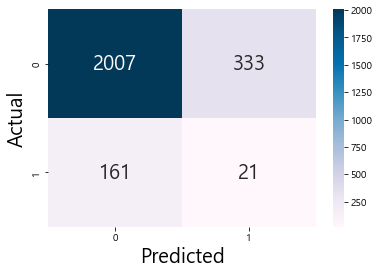

In [41]:
logistic = Logistic(df_over)

# 3. DT

In [17]:
def DT(df):
    X_train, X_test, y_train, y_test = data_year(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['gini','entropy','log_loss'],   # 기본적으로 gini가 사용, 엔트로피 : 균형적인 트리
                    'splitter' : ['best', 'random'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 4, 5],
                    'class_weight' : ['balanced']}
    
    scaler = RobustScaler()
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv = KFold(n_splits=5, shuffle = True, random_state=42), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    print('\n예측 데이터 정확도')
    score(y_test, pred)
    
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)


In [18]:
def DT_vis(df, best_model):
    export_graphviz(best_model.best_estimator_, out_file='트리확인후삭제.dot', class_names=["0", "1"], feature_names= df.drop(['y'], axis=1).columns, impurity=True, filled=True)

    with open('트리확인후삭제.dot', encoding='utf-8') as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.2645912857962439

예측 데이터 정확도
accuracy score : 0.833
precision score : 0.236
recall score : 0.588
f1 score : 0.336
roc score : 0.720
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.73949    0.16596 0.64835   0.26428    0.69747
0.30000   0.79619    0.19818 0.59890   0.29781    0.70522
0.40000   0.83267    0.23568 0.58791   0.33648    0.71981
0.50000   0.83267    0.23568 0.58791   0.33648    0.71981
0.60000   0.83267    0.23568 0.58791   0.33648    0.71981
0.70000   0.87589    0.30448 0.56044   0.39458    0.73043
0.80000   0.90603    0.38397 0.50000   0.43437    0.71880
0.90000   0.92665    0.48800 0.33516   0.39739    0.65391
None


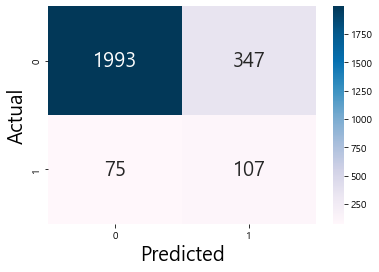

In [19]:
df_tree = DT(df_over)

# 3. SVM

In [26]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data_year(df)

    svc = SVC(probability=True)
    param_svc = {'C' : [1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.5], # 1 / (n_features * X.var())
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=KFold(n_splits=5, shuffle = True, random_state=30), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    return gridsearch.fit(X_train, y_train)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.5, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.0

예측 데이터 정확도
accuracy score : 0.928
precision score : 0.000
recall score : 0.000
f1 score : 0.000
roc score : 0.500


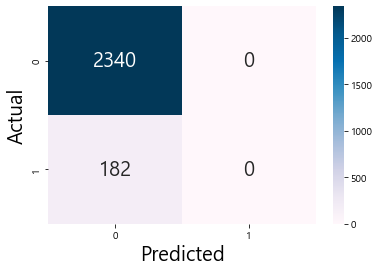

In [27]:
svm = SVM(df_over, 'rbf')

# 4. RandomForest

In [22]:
def RF(df):
    X_train, X_test, y_train, y_test = data_year(df)
    rf = RandomForestClassifier()
    
    params_rf = {
        'n_estimators':[400],
        'max_depth' : [4], 
        'min_samples_leaf' : [4, 6],
        'min_samples_split' : [ 12, 14, 16]
    }

    gridsearch = GridSearchCV(rf , param_grid=params_rf , cv=KFold(n_splits=5, shuffle = True, random_state=121), n_jobs=-1 )
    gridsearch.fit(X_train, y_train)
    warnings.filterwarnings('ignore')

    
    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    print('최적 하이퍼 파라미터:\n', gridsearch.best_params_)
    print('최고 예측 정확도: {0:.4f}'.format(gridsearch.best_score_))
    score(y_test, pred)
    
    # # feature_importance 보여주기
    ftr_importances_values = estimator.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

    plt.figure(figsize=(8,6))
    plt.title('Feature importances')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()


    return gridsearch.fit(X_train, y_train)

최적 하이퍼 파라미터:
 {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 14, 'n_estimators': 400}
최고 예측 정확도: 0.9671
accuracy score : 0.933
precision score : 0.875
recall score : 0.077
f1 score : 0.141
roc score : 0.538


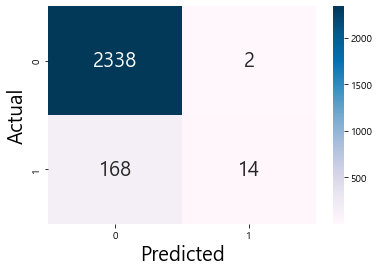

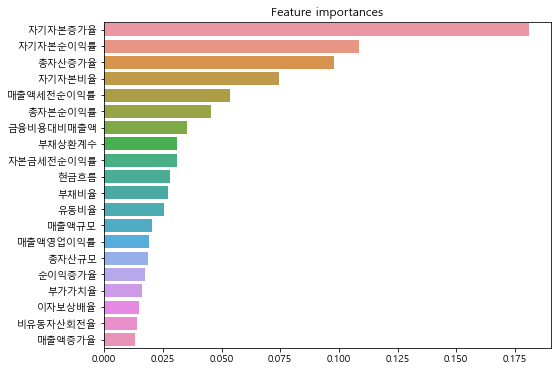

In [23]:
rf = RF(df_over)

# 5. LightGBM

In [24]:
def LGBM(df):
    import re
    X_train, X_test, y_train, y_test = data_lgbm_year(df)
    lgbm = LGBMClassifier()
    
    params = {
    'n_estimators':[200, 300, 400],
        'max_depth' : [4, 5, 6, 7, 8], 
    'min_data_in_leaf' : [8, 10, 12, 14, 16]
    }
    
    # 조기 중단 추가
    evals = [(X_train, y_train)]
    gridsearch = GridSearchCV(lgbm , param_grid=params , cv=KFold(n_splits=5, shuffle = True, random_state=42), n_jobs=-1 )
    gridsearch.fit(X_train , y_train,early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=0)


    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    print('최적 하이퍼 파라미터:\n', gridsearch.best_params_)
    print('최고 예측 정확도: {0:.4f}'.format(gridsearch.best_score_))
    score(y_test, pred)
    
    # feature_importance 보여주기
    ftr_importances_values = estimator.feature_importances_
    ftr_importances = pd.DataFrame({'Value':ftr_importances_values,'Feature':X_train.columns})

    plt.figure(figsize=(8,6))
    sns.barplot(x="Value", y="Feature", data=ftr_importances.sort_values(by="Value",ascending=False)[:20])
    plt.title('LightGBM Features')
    plt.show()
    return gridsearch.fit(X_train , y_train,early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=0)

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_data_in_leaf': 16, 'n_estimators': 200}
최고 예측 정확도: 0.9701
accuracy score : 0.935
precision score : 0.711
recall score : 0.176
f1 score : 0.282
roc score : 0.585


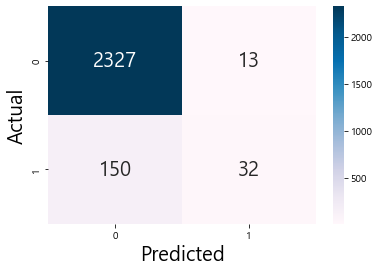

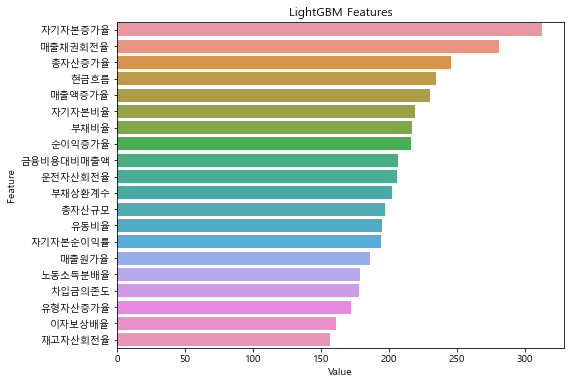

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


In [25]:
lgbm = LGBM(df_over)

# 6. XGB

In [139]:
def XGB(df):
    X_train, X_test, y_train, y_test = data_year(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'learning_rate' : [0.01],    # 나중에 한 번 더 확인
               'n_estimators' : [400],
               'min_child_weight' : [3],  ###
               'gamma' : [1.0],    ###
               'max_depth' : [5],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.8],
               'colsample_bylevel' : [0.6],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['y']==0])/len(df[df['y']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=KFold(n_splits=5, shuffle = True, random_state=42), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    print('\n예측 데이터 정확도')
    score(y_test, pred)
    
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))
    return gridsearch.fit(X_train, y_train)

[17:47:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 21.727078891257996, 'silent': 1}
학습 데이터 정확도 :  0.8431824616324658

예측 데이터 정확도
accuracy score : 0.662
precision score : 0.153
recall score : 0.813
f1 score : 0.258
roc score : 0.732
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.44132    0.10648 0.91209   0.19070    0.65839
0.30000   0.53608    0.12117 0.86813

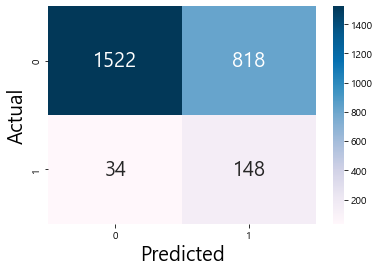

In [140]:
xgb = XGB(df_over)

# 7. Voting

In [141]:
def SV(df):
    import re
    X_train, X_test, y_train, y_test = data_lgbm_year(df)

    estimators = [['lr', logistic.best_estimator_],
                  ['rf', rf.best_estimator_],
                  ['dt', df_tree.best_estimator_],
                  ['svm', svm.best_estimator_],
                  ['lgbm',lgbm.best_estimator_],
                  ['xgb', xgb.best_estimator_]]  # 모델 집합
    
    SV = VotingClassifier(estimators, voting="soft",n_jobs=-1)
    SV.fit(X_train, y_train)
    pred = pd.DataFrame(SV.predict(X_test))
    
    print('\n예측 데이터 정확도')
    score(y_test, pred)
    
    pred_probability = pd.DataFrame(SV.predict_proba(X_test))
    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))
    return SV.fit(X_train, y_train)


예측 데이터 정확도
accuracy score : 0.868
precision score : 0.289
recall score : 0.571
f1 score : 0.384
roc score : 0.731
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.26487    0.08614 0.95604   0.15804    0.58358
0.30000   0.62807    0.14540 0.85165   0.24840    0.73117
0.40000   0.80769    0.23280 0.72527   0.35247    0.76969
0.50000   0.86757    0.28889 0.57143   0.38376    0.73101
0.60000   0.90563    0.37156 0.44505   0.40500    0.69325
0.70000   0.92982    0.52525 0.28571   0.37011    0.63281
0.80000   0.92784    0.00000 0.00000   0.00000    0.50000
0.90000   0.92784    0.00000 0.00000   0.00000    0.50000
None


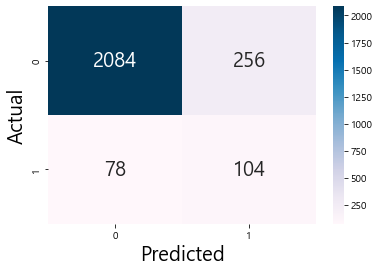

In [142]:
sv = SV(df_over)

# 8. Stacking Ensemble

In [106]:
# 개별모델 내부에서 CV 적용해 Stacking하는 함수 구현
def get_stacking_datasets(model,df,n_folds=5):

    import re
    X_train, X_test, y_train, y_test = data_lgbm_year(df)
    
    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((X_train.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((X_test.shape[0], n_folds))
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_folds, shuffle=True, random_state=42).split(X_train)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        X_train_ = X_train.iloc[train_idx]
        y_train_ = y_train.iloc[train_idx]
        X_test_ = X_train.iloc[valid_idx]
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(X_train_, y_train_)
        train_fold_pred[valid_idx, :] = model.predict(X_test_).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(X_test)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [119]:
def stacking(df):
    
    X_train, X_test, y_train, y_test = data_lgbm_year(df)
    
    xgb_train, xgb_test = get_stacking_datasets(xgb.best_estimator_, df, 5)
    lo_train, lo_test = get_stacking_datasets(logistic.best_estimator_, df, 5)
    rf_train, rf_test = get_stacking_datasets(rf.best_estimator_, df, 5)
    dt_train, dt_test = get_stacking_datasets(df_tree.best_estimator_, df, 5)
    svm_train, svm_test = get_stacking_datasets(svm.best_estimator_, df, 5)

    
    new_X_train = np.concatenate((lo_train, rf_train, dt_train), axis = 1)
    new_X_test = np.concatenate((lo_test, rf_test,dt_test), axis = 1)
    
    # meta learner
    lgbm.best_estimator_.fit(new_X_train, y_train)
    y_test = pd.DataFrame(y_test)
    stack_pred = pd.DataFrame(lgbm.best_estimator_.predict(new_X_test))
    print('\n예측 데이터 정확도')
    score(y_test, stack_pred)

XGBClassifier 모델 시작
 Fold 횟수 : 1
[15:57:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 Fold 횟수 : 2
[15:57:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 Fold 횟수 : 3
[15:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameter

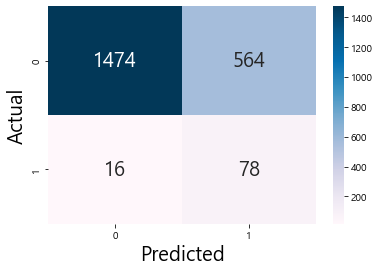

In [120]:
stacking(df_over)

# 9. DNN

In [143]:
#F1-score
from tensorflow.keras import backend as K
def custom_f1(y_target, y_pred):    
    def recall(y_target, y_pred):
    
        y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
        y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

        count_true_positive = K.sum(y_target_yn * y_pred_yn) 
        count_true_positive_false_negative = K.sum(y_target_yn)

        # Recall =  (True Positive) / (True Positive + False Negative)
        # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
        recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
        return recall


    def precision(y_target, y_pred):
    
        y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
        y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

        count_true_positive = K.sum(y_target_yn * y_pred_yn) 
        count_true_positive_false_positive = K.sum(y_pred_yn)

        # Precision = (True Positive) / (True Positive + False Positive)
        # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
        precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

        # return a single tensor value
        return precision

    precision, recall = precision(y_target, y_pred), recall(y_target, y_pred)

    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    return ( 2 * recall * precision) / (recall + precision+ K.epsilon())

In [144]:
def build_classifier(optimizer, n_units, n_layers):
    classifier = Sequential()
    classifier.add(Dense(units = n_units, kernel_initializer = 'uniform', activation = 'relu', input_dim = 47)) # kernel_initializer는 default값
    
    for i in range(n_layers):
        classifier.add(Dense(units = n_units, kernel_initializer = 'uniform', activation = 'relu'))
        
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = [custom_f1])
    return classifier

In [145]:
# DNN은 GridSearchcv 너무 오래걸리기 때문에 random search로 진행
from sklearn.model_selection import RandomizedSearchCV
def DNN(df):
    X_train, X_test, y_train, y_test = data_year(df)

    classifier = KerasClassifier(build_fn = build_classifier)
    parameters = {
        'batch_size': [10,20,40,80],
        'epochs': [100,200],
        'optimizer': ['adam', 'rmsprop'],
        'n_units': [10, 20, 30],
        'n_layers': [1,2,3]
    }
    
    random_search = RandomizedSearchCV(classifier, param_distributions=parameters, cv=KFold(n_splits=5, shuffle = True, random_state=42), scoring = 'f1', n_jobs=-1, verbose = 1)
    random_search = random_search.fit(X_train, y_train)
    # print('최적 파라미터\n', random_search.best_params_)
    # print('학습 데이터 정확도 : ', random_search.best_score_)
    
    estimator = random_search.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    
    print('\n예측 데이터 정확도')
    score(y_test, pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
785/785 [==============================] - 1s 618us/step - loss: 653.1768 - custom_f1: 0.7670
Epoch 2/100
785/785 [==============================] - 1s 639us/step - loss: 38.1513 - custom_f1: 0.8164
Epoch 3/100
785/785 [==============================] - 1s 673us/step - loss: 26.1586 - custom_f1: 0.8336
Epoch 4/100
785/785 [==============================] - 1s 662us/step - loss: 71.6047 - custom_f1: 0.8433
Epoch 5/100
785/785 [==============================] - 1s 678us/step - loss: 13.1902 - custom_f1: 0.8553
Epoch 6/100
785/785 [==============================] - 1s 653us/step - loss: 2.1236 - custom_f1: 0.8635
Epoch 7/100
785/785 [==============================] - 1s 734us/step - loss: 0.8666 - custom_f1: 0.8697
Epoch 8/100
785/785 [==============================] - 1s 843us/step - loss: 0.5721 - custom_f1: 0.8756
Epoch 9/100
785/785 [==============================] - 1s 723us/step - loss: 0.3540 - custom_f1: 0.87

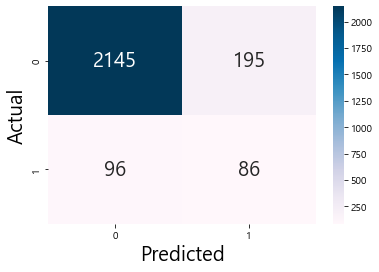

In [146]:
DNN(df_over)